This notebook contains code for traning a RandomForest regressor to predict measurement biases of miRXplore datasets from TGIRT-seq.

The [R RandomForest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) model is being used here becuase neither [scikit-learn randomforest](https://github.com/scikit-learn/scikit-learn/issues/5442) nor the *train* module from [caret](https://stats.stackexchange.com/questions/135671/how-does-caret-handle-factors) can handle categorically-labeled data.

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sequencing_tools.viz_tools import color_encoder, simpsons_palette, mixed_sort
from helper_function import *
from feature_selection import make_pca_df, pca_biplot, loading_plot
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
h2o.init()

def rename_col(x):
    out = ''
    if 'head' in x:
        out = '+' + str(int(x.replace('head','')) + 1)
    elif 'tail' in x:
        pos = re.search('[0-9]+$', x).group(0)
        pos = int(pos) - 3
        out = str(pos)
    return out

def train_to_cat(d):
    for col in d.columns:
        if col != 'Y':
            d[col] = d[col].astype('category')
    return d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 mins 10 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,8 months !!!
H2O cluster name:,H2O_from_python_cdw2854_7vrml0
H2O cluster total nodes:,1
H2O cluster free memory:,25.75 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"locked, healthy"


Reading in miRNA count data, combining counts from replicates and only look at NTT data, the first and last 3 nucleotides of each miRNA are extracted as predictors, $\Delta log10$ CPM is computed and will be used as target:

In [8]:
df = pd.read_feather('../data/miR_count.feather') \
    .groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .drop('index', axis=1)
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,prep,seq_id,seq_count,head0,head1,head2,tail0,tail1,tail2,cpm,expected_cpm,Y
0,NTT,EBV-1-1,401,T,A,A,G,T,T,11.747525,1039.50104,-1.946879
1,NTT,EBV-1-2,42861,T,A,T,T,G,A,1255.637604,1039.50104,0.082039
2,NTT,EBV-1-2-star,2508,A,A,A,A,G,C,73.473300,1039.50104,-1.150695
3,NTT,EBV-1-3,3964,T,A,A,A,C,A,116.127656,1039.50104,-0.951889
4,NTT,EBV-1-3P,3684,T,A,G,G,T,C,107.924895,1039.50104,-0.983703


In [9]:
model_df = df.filter(regex = 'head|tail|Y') \
    .pipe(train_to_cat)
model_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,head0,head1,head2,tail0,tail1,tail2,Y
0,T,A,A,G,T,T,-1.946879
1,T,A,T,T,G,A,0.082039
2,A,A,A,A,G,C,-1.150695
3,T,A,A,A,C,A,-0.951889
4,T,A,G,G,T,C,-0.983703


# K-fold cross-validation #

20% of the data is partitioned out as test set, other 80% goes into an 8-fold cross-validation

In [10]:
train_df, test_df = train_test_split(model_df, test_size=0.2)

Collect predictions and variable importances from each fold 

In [45]:
kf = KFold(n_splits = 8)
rf = H2ORandomForestEstimator()
res_df = []
var_df = []
target_id = 'Y'
train_id = model_df.filter(regex='head|tail').columns.tolist()
for i, (train_idx, test_idx) in enumerate(kf.split(train_df)):
    sub_train_df = train_df.iloc[train_idx,:].reset_index()
    sub_test_df = train_df.iloc[test_idx].reset_index()
    
    rf.train(train_id, target_id, training_frame=h2o.H2OFrame.from_python(sub_train_df))
    pred = rf.predict(h2o.H2OFrame.from_python(sub_test_df))
    sub_test_df['pred'] = pred.as_data_frame()
    
    var = rf._model_json['output']['variable_importances']\
        .as_data_frame()\
        .assign(k = i)

    var_df.append(var)
    res_df.append(pd.DataFrame({'pred': sub_test_df['pred'], 
                                'Y': sub_test_df['Y'], 
                                'k': i}))
    #print(sub_test_df.shape)
res_df = pd.concat(res_df)
var_df = pd.concat(var_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

In [46]:
var_df

,variable,relative_importance,scaled_importance,percentage,k
0,tail2,7398.319824,1.000000,0.529347,0
1,head0,1800.565430,0.243375,0.128830,0
2,head1,1741.481689,0.235389,0.124602,0
3,head2,1215.593140,0.164307,0.086975,0
4,tail1,1016.010986,0.137330,0.072695,0
5,tail0,804.334106,0.108718,0.057550,0
0,tail2,6627.065918,1.000000,0.493239,1
1,head0,1949.705933,0.294203,0.145113,1
2,head1,1738.113892,0.262275,0.129364,1
3,head2,1263.895142,0.190717,0.094069,1


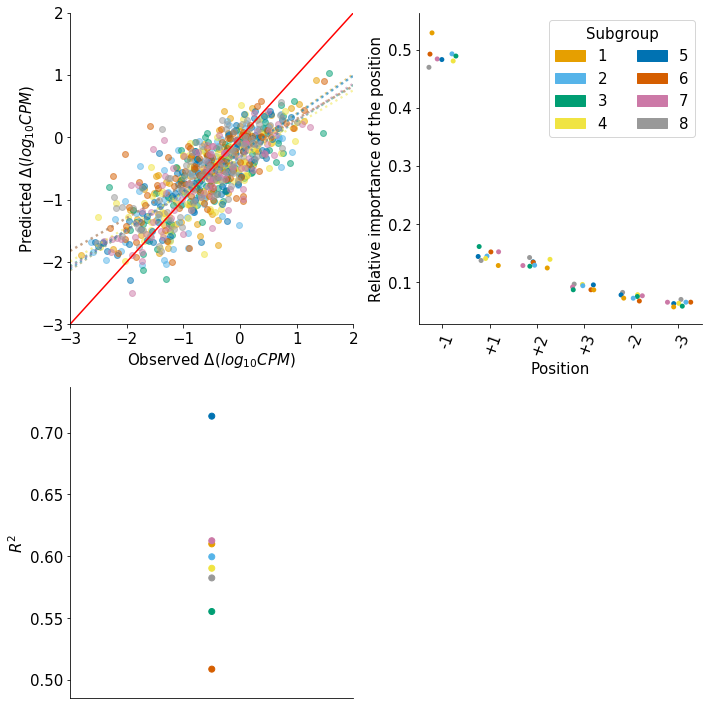

In [48]:
ce = color_encoder()
ce.fit(res_df.k+1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])
for k, k_df in res_df.groupby('k'):
    sns.regplot(k_df.Y, k_df.pred, 
                label = k + 1, 
                color = ce.encoder[k+1],
                ci = None, 
                truncate=False,
                line_kws = {'alpha': 0.5, 'linestyle':':'},
                scatter_kws = {'alpha' : 0.5})
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$')

ax.legend().set_visible(False)

    
ax = fig.add_subplot(222)
var_plot_df = var_df\
    .rename(columns = {'percentage':'imp_score'})\
    .sort_values('imp_score', ascending=False)\
    .assign(variable = lambda d: d.variable.map(rename_col))\
    .assign(imp_score = lambda d: d.groupby('k').imp_score.transform(lambda x: x/x.sum()))
sns.stripplot(data = var_plot_df,
              order = var_plot_df.variable.unique(),
              jitter=0.3,
              y = 'imp_score', 
              x=  'variable', 
              hue = 'k', palette = list(ce.encoder.values()),
              color = 'steelblue', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, 
                   rotation_mode =  'anchor', ha = 'right')
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of the position')
lgd = ce.show_legend(ax, title = 'Subgroup', fontsize=15, ncol=2)
lgd.get_title().set_fontsize('15')
    
ax = fig.add_subplot(223)
r2_df = res_df\
    .groupby('k')\
    .apply(lambda d: r2_score(d.Y,d.pred))\
    .transform(pd.DataFrame)\
    .reset_index()\
    .rename(columns={0:'r2'}) \
    .assign(colors = lambda d: d['k'].map(lambda k: ce.encoder[k+1]))
ax.scatter(y = r2_df['r2'], x = r2_df.shape[0] * [1],
         color = r2_df.colors.tolist())
ax.xaxis.set_visible(False)
ax.set_ylabel('$R^2$')


#ax = fig.add_subplot(224)
#scale = np.arange(-3,3)
#ax.set_xticks(scale)
#ax.set_yticks(scale)
#ax.set_xlim(scale[0], scale[-1])
#ax.set_ylim(scale[0], scale[-1])
## train RF with full train_df
#r_train_df = pandas2ri.DataFrame(train_df)
#formula = Formula('Y~.')
#fitted_rf = rf.randomForest(formula = formula, data = r_train_df)

## predict on full test_df
#test_df['pred'] = pandas2ri.ri2py_vector(stats.predict(fitted_rf, pandas2ri.DataFrame(test_df)))
#sns.regplot(data=test_df, x = 'Y', y = 'pred', ax = ax, ci = False,
#            line_kws = {'alpha': 1, 'linestyle':':'})
#ax.plot([-5,3], [-5,3], color='red')
#ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
#ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
#r2 = r2_score(test_df.Y, test_df.pred)
#ax.text(-2,1, '$R^2 = %.3f$ '%(r2), fontsize=15)
#ax.legend().set_visible(False)


sns.despine()
fig.tight_layout()
#figurename = figure_path + '/rf_cv.pdf'
#fig.savefig(figurename, bbox_inches='tight')

#figurename = figure_path + '/rf_cv.eps'
#fig.savefig(figurename, bbox_inches='tight')

# Test other nucleotides #

Here, I will use nucleotides other than the first and last 3 bases from each miRNA as predictors and address how random-forest will capture unwanted patterns

In [57]:
def test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model = False):

    label = 'End nucleotides' if set(nucleotides) - set([0,1,2,-3,-2,-1]) == set() else 'Random predictors'
    df = pd.read_feather('../data/miR_count.feather') \
        .groupby(["prep","seq_id"], as_index=False) \
        .agg({'seq_count':'sum'})\
        .merge(get_seq_base(shuffle = nucleotides))\
        .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
        .assign(expected_cpm = lambda d: 1e6 / 962) \
        .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
        .query('prep == "NTT"')\
        .reset_index() 

    model_df = df.filter(regex = 'head|tail|Y')\
        .pipe(train_to_cat)
    # set random_state to preserve same test set between two models
    train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=4)     
    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)
    rf.train(train_id, target_id, training_frame = h2o.H2OFrame.from_python(train_df))
    pred = rf.predict(h2o.H2OFrame.from_python(test_df))
    test_df['predict'] = pred.as_data_frame()
    if return_model:
        return test_df.assign(label = label), rf
    
    else:
        return test_df.assign(label = label)

In [58]:
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6])
random_df.append(t_df)
t_df, fitted_rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True)
random_df.append(t_df)
random_df = pd.concat(random_df)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [63]:
rf._model_json['output']['variable_importances']\
        .as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,tail2,6421.778809,1.000000,0.471348
1,head1,2008.659790,0.312789,0.147432
2,head0,1983.147217,0.308816,0.145560
3,head2,1260.085938,0.196221,0.092488
4,tail1,1055.949341,0.164433,0.077505
5,tail0,894.669128,0.139318,0.065667


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


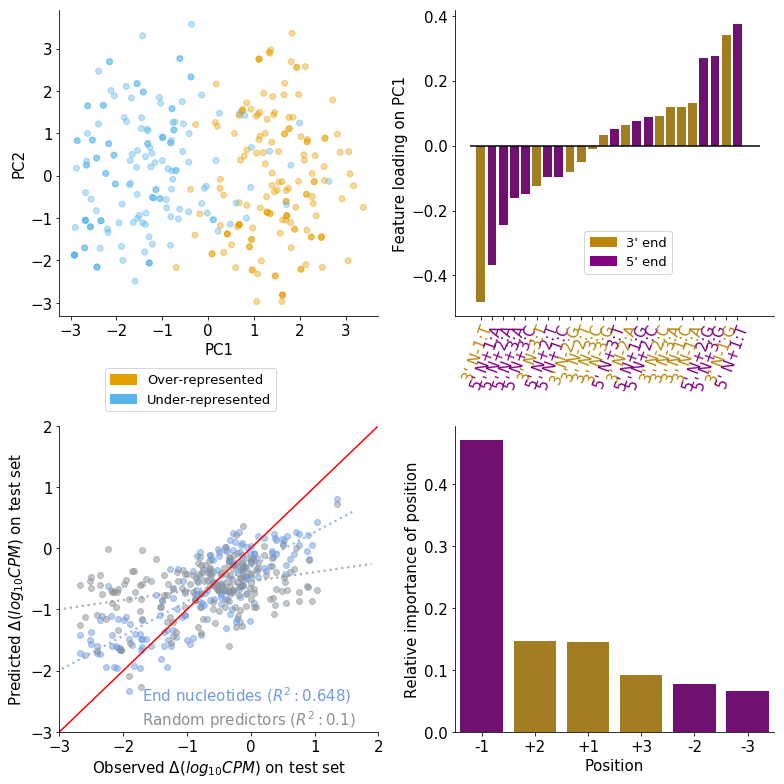

In [66]:
prep_ce = color_encoder()

plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

    
fig = plt.figure(figsize = (11,11))
biplot = fig.add_subplot(221)
pcplot = fig.add_subplot(222)
pca_df = make_pca_df()
pca, pc_df = pca_biplot(pca_df, biplot)
loading_plot(pca_df,pca, pcplot)


ax = fig.add_subplot(223)
for i, ((label, color), lab_df) in enumerate(plot_random_df.groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])



ax = fig.add_subplot(224)
var_df = rf._model_json['output']['variable_importances']\
        .as_data_frame() \
    .sort_values('percentage', ascending=False)\
    .assign(imp_score = lambda d: d.percentage)\
    .assign(x = lambda d: d.variable.map(rename_col))\
    .assign(color = lambda d: np.where(d.x.str.contains('-'), 'purple', 'darkgoldenrod'))
sns.barplot(data = var_df, x = 'x', y = 'imp_score', 
            ax = ax, order = var_df['x'],
            palette = var_df.color.tolist())
ax.legend().set_visible(False)
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of position')

fig.tight_layout()
sns.despine()
#figurename = figure_path + '/rf_control.pdf'
#fig.savefig(figurename, bbox_inches='tight')
#figurename = figure_path + '/rf_control.eps'
#fig.savefig(figurename, bbox_inches='tight')

In [67]:
var_df.groupby('color').agg({'imp_score':'sum'})

,imp_score
color,
darkgoldenrod,0.38548
purple,0.61452


# Corrections #

Training the model on combined NTT dataset, and apply the model on other samples

In [44]:
df = pd.read_feather('../data/miR_count.feather')  \
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1])) 
df.head()

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,index,seq_id,seq_count,samplename,cpm,prep,head0,head1,head2,tail0,tail1,tail2
0,0,EBV-10,128,NTT5_noTA,30.911005,NTT-noTA,T,A,C,T,G,T
1,0,EBV-10,430,MiR_NTM2,41.924719,Diaminopurine,T,A,C,T,G,T
2,0,EBV-10,285,MiR_R3,44.457360,NTC,T,A,C,T,G,T
3,0,EBV-10,1140,MiR_NTTR2,108.568575,NTTR,T,A,C,T,G,T
4,0,EBV-10,254,MiR_NTT2,23.778512,NTT,T,A,C,T,G,T


In [47]:
train_df =  df.groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .filter(regex='head|tail|Y') \
    .pipe(train_to_cat)
train_df.head()

,head0,head1,head2,tail0,tail1,tail2,Y
0,T,A,A,G,T,T,-1.946879
1,T,A,T,T,G,A,0.082039
2,A,A,A,A,G,C,-1.150695
3,T,A,A,A,C,A,-0.951889
4,T,A,G,G,T,C,-0.983703


In [48]:
r_train_df = pandas2ri.DataFrame(train_df)
formula = Formula('Y~.')
final_model = rf.randomForest(formula = formula, data = r_train_df)

In [ ]:
corrected_df = df \
    .assign(predicted = pandas2ri.ri2py_vector(stats.predict(final_model, pandas2ri.DataFrame(df))))\
    .assign(log10_cpm = lambda d: np.log10(d.cpm))\
    .assign(pseudocount = lambda d: np.power(10, d.log10_cpm - d.predicted)) \
    .filter(regex='seq|sample|count|prep')\
    .pipe(pd.melt, id_vars = ['seq_id','prep','samplename'], var_name = 'count_type', value_name = 'seq_count') \
    .query('count_type != "seq_count"')\
    .assign(samplename = lambda d: d.samplename + ' (Corrected)')\
    .assign(prep = lambda d: d.prep + ' (Corrected)')\
    .drop('count_type', axis=1) \
    .reset_index()
corrected_df.to_feather('corrected_count.feather')
corrected_df.head()